## Downloading dataset

In [1]:
!kaggle datasets download jessicali9530/stanford-dogs-dataset -p data -o --unzip

 97% 729M/750M [00:10<00:00, 74.5MB/s]
100% 750M/750M [00:10<00:00, 72.8MB/s]


Although setting seed cannot help with getting rid of randomness due to GPU usage, it can reduce it

In [2]:
import numpy as np
import tensorflow as tf
import random

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

This is just for visualisation

In [3]:
import os 

def print_progress_bar(iteration: int, total: int, progress: str = ''):
    percent = f"{100 * (iteration / float(total)):3.2f}"
    progress = (progress + " progress") if progress != "" else "Progress"
    length = 127 - len(progress) - len(percent) - 15
    filled_length = int(length * iteration // total)
    bar = '=' * filled_length + ('>' if filled_length + 1 <= length else '') + ' ' * (length - filled_length - 1)
    print(f'\r{progress}: |{bar}| {percent}% Complete', end='\n' if iteration == total else '')

## Preprocessing data

### Cropping images

In [4]:
from PIL import Image
import xml.etree.ElementTree as ET
from glob import glob
import shutil


images_dir = 'data/images/Images'
annots_dir = 'data/annotations/Annotation'
cropps_dir = 'data/cropped_images'


def save_cropped_img(path, annotation, newpath):
    root = ET.parse(annotation).getroot()
    xmin = int(root.findall('.//xmin')[0].text)
    xmax = int(root.findall('.//xmax')[0].text)
    ymin = int(root.findall('.//ymin')[0].text)
    ymax = int(root.findall('.//ymax')[0].text)
    image = Image.open(path)
    image = image.crop((xmin, ymin, xmax, ymax))
    image = image.convert('RGB')
    image.save(newpath)

def crop_images():
    total_images = 0
    for directory in glob(f'{images_dir}/*'):
        total_images += len(glob(f'{directory}/*.jpg'))
    
    iteration = 0
    print_progress_bar(iteration, total_images, progress='Cropping')
    for breed in os.listdir(images_dir):
        os.makedirs(f'{cropps_dir}/{breed[10:].capitalize()}', exist_ok=True)
        
        for image in os.listdir(os.path.join(images_dir, breed)):
            save_cropped_img(f'{images_dir}/{breed}/{image}', 
                             f'{annots_dir}/{breed}/{image[:-4]}', 
                             f'{cropps_dir}/{breed[10:].capitalize()}/{image}')
            iteration += 1
            print_progress_bar(iteration, total_images, progress='Cropping')
    return total_images

total_images = crop_images()

shutil.rmtree(images_dir)
shutil.rmtree(annots_dir)

Cropping progress: |====================================================================| 100.00% Complete


### Splitting into subsets

In [5]:
TEST_SIZE = 0.1
VAL_SIZE = 0.1

iteration = 0
print_progress_bar(iteration, total_images, progress='Splitting')

for breed in os.listdir(cropps_dir):
    os.makedirs(f'data/train/{breed}', exist_ok=True)
    os.makedirs(f'data/val/{breed}', exist_ok=True)
    os.makedirs(f'data/test/{breed}', exist_ok=True)
    images = glob(f'{cropps_dir}/{breed}/*.jpg')
    
    for image in images[:int(len(images) * (1 - TEST_SIZE - VAL_SIZE))]:
        shutil.copy(image, f'data/train/{breed}')
        iteration += 1
        print_progress_bar(iteration, total_images, progress='Splitting')
        
    for image in images[int(len(images) * (1 - TEST_SIZE - VAL_SIZE)):int(len(images) * (1 - TEST_SIZE))]:
        shutil.copy(image, f'data/val/{breed}')
        iteration += 1
        print_progress_bar(iteration, total_images, progress='Splitting')
        
    for image in images[int(len(images) * (1 - TEST_SIZE)):]:
        shutil.copy(image, f'data/test/{breed}')
        iteration += 1
        print_progress_bar(iteration, total_images, progress='Splitting')

Splitting progress: |===================================================================| 100.00% Complete


## Training model

In [6]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using callbacks is pretting cool. For example, if training progress is stacked because of too high learning rate, __ReduceLROnPlateau__ can reduce its value. In principle, it is clear from the names what they do.

In [7]:
callbacks = [
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_acc',
        save_best_only=True
    ),
    CSVLogger(
        filename='history.csv'  
    ),
    EarlyStopping(
        monitor='val_acc',
        min_delta=1e-4,
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_acc',
        factor=0.6,
        patience=5,
        min_lr=3e-6,
    ),
]

In [8]:
target_size = (160, 160)
batch_size = 50

So why did I create special function <b>conv2d</b> and don't use just Conv2D from tf.keras.layers? Because of keras' Conv2D does not have <i>BatchNormalization</i> by default. If you want to know about this technique read <a href="https://arxiv.org/pdf/1502.03167.pdf">this</a>.

What it <i>inception block</i>? Oh dear, you definitely should read this one <a href="https://arxiv.org/pdf/1409.4842.pdf">Going deeper with convolutions</a>.

By the way I'm also using <i>short connections</i> later. So there is some <a href="https://arxiv.org/pdf/1512.03385.pdf">info</a>.

In [9]:
def conv2d(filters, kernel_size, prev_layer, activation='relu'):
    layer = Conv2D(filters, kernel_size, padding='same')(prev_layer)
    layer = BatchNormalization()(layer)
    layer = Activation(activation)(layer)
    return layer

def inception_block(n_filters, prev_layer, compress_to=None):
    layer_conv11 = conv2d(n_filters, (1, 1), prev_layer)
    if compress_to is None:
        layer_conv33 = conv2d(n_filters, (3, 3), prev_layer)
        layer_conv55 = conv2d(n_filters, (5, 5), prev_layer)
    else:
        layer_conv33 = conv2d(n_filters, (3, 3), conv2d(compress_to, (1, 1), prev_layer))
        layer_conv55 = conv2d(n_filters, (5, 5), conv2d(compress_to, (1, 1), prev_layer))
    return concatenate([
        layer_conv11, layer_conv33, layer_conv55
    ])

And now let's mix up all techniques we've got.

In [10]:
base_model = MobileNetV2(
    include_top=False, 
    input_shape=(*target_size, 3)
)

layer = inception_block(256, base_model.output, compress_to=128)
layer = inception_block(512, layer, compress_to=128)
layer = concatenate([
    GlobalAvgPool2D()(layer),
    GlobalAvgPool2D()(base_model.output),
]) 
layer = Dense(256, activation='relu')(layer)
layer = BatchNormalization()(layer)
out = Dense(120, activation='softmax')(layer)

model = Model(inputs=base_model.input, outputs=out)

def top_2_acc(x, y):
    return top_k_categorical_accuracy(x, y, 2)

model.compile(optimizer=Adam(lr=8e-5),
              loss='categorical_crossentropy',
              metrics=["acc", top_2_acc])

This is for data augmentation. An attempt to avoid overfitting.

In [11]:
data_generator = ImageDataGenerator(
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=10,
    brightness_range=[0.7, 1.3],
    channel_shift_range=0.15,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

train_generator = data_generator.flow_from_directory(
    'data/train',
    target_size=target_size,
    batch_size=batch_size,
)
val_generator = data_generator.flow_from_directory(
    'data/val',
    target_size=target_size,
    batch_size=batch_size,
)

Found 16986 images belonging to 120 classes.
Found 1859 images belonging to 120 classes.


In [12]:
%%time

history = model.fit(
    train_generator, 
    epochs=150,
    steps_per_epoch=len(train_generator), 
    validation_data=val_generator, 
    validation_steps=len(val_generator),
    callbacks=callbacks)

Train for 340 steps, validate for 38 steps
Epoch 1/150
340/340 [==============================] - 174s 511ms/step - loss: 2.4631 - acc: 0.4417 - top_2_acc: 0.5679 - val_loss: 1.4516 - val_acc: 0.6127 - val_top_2_acc: 0.7676
Epoch 2/150
340/340 [==============================] - 172s 506ms/step - loss: 1.0100 - acc: 0.7244 - top_2_acc: 0.8584 - val_loss: 1.1531 - val_acc: 0.6643 - val_top_2_acc: 0.8117
Epoch 3/150
340/340 [==============================] - 171s 503ms/step - loss: 0.7057 - acc: 0.8025 - top_2_acc: 0.9138 - val_loss: 1.0533 - val_acc: 0.7004 - val_top_2_acc: 0.8289
Epoch 4/150
340/340 [==============================] - 167s 490ms/step - loss: 0.5247 - acc: 0.8541 - top_2_acc: 0.9460 - val_loss: 0.9065 - val_acc: 0.7348 - val_top_2_acc: 0.8709
Epoch 5/150
340/340 [==============================] - 162s 476ms/step - loss: 0.3887 - acc: 0.8935 - top_2_acc: 0.9649 - val_loss: 0.9648 - val_acc: 0.7257 - val_top_2_acc: 0.8591
Epoch 6/150
340/340 [==============================]

## Evaluating model

In [13]:
dg = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = dg.flow_from_directory(
    'data/val',
    target_size=target_size,
    batch_size=batch_size,
)
test_generator = dg.flow_from_directory(
    'data/test',
    target_size=target_size,
    batch_size=batch_size,
)

Found 1850 images belonging to 120 classes.
Found 1909 images belonging to 120 classes.


In [14]:
val_score = model.evaluate(val_generator)
test_score = model.evaluate(test_generator)

print()
print(f'Validation accuracy: {val_score[1]:<8.4}   Validation top 2 accuracy: {val_score[2]:<8.4}')
print(f'Testing accuracy:    {test_score[1]:<8.4}   Testing top 2 accuracy:    {test_score[2]:<8.4}')

39/39 [==============================] - 3s 82ms/step - loss: 0.2380 - acc: 0.9460 - top_2_acc: 0.9764
Validation accuracy: 0.9486     Validation top 2 accuracy: 0.9773  
Testing accuracy:    0.946      Testing top 2 accuracy:    0.9764  


## Hell yeah.  
  
  
__94.6%__ of accuracy, __97.64%__ of top 2 accuracy.  

Even I can't predict better

## Okey, GRAPH TIME

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
df = pd.read_csv('history.csv', index_col='epoch')
df.head(3)

,acc,loss,top_2_acc,val_acc,val_loss,val_top_2_acc
epoch,,,,,,
0,0.441658,2.462501,0.567879,0.612695,1.451629,0.767617
1,0.724420,1.010405,0.858354,0.664336,1.153066,0.811727
2,0.802543,0.706073,0.913752,0.700377,1.053343,0.828940


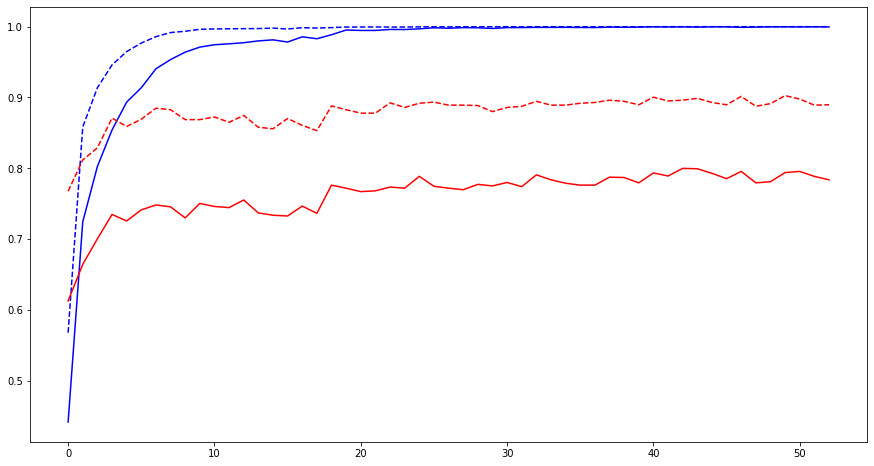

In [17]:
plt.figure(figsize=[15,8])
plt.plot(df.acc, 'b')
plt.plot(df.top_2_acc, 'b--')
plt.plot(df.val_acc, 'r')
plt.plot(df.val_top_2_acc, 'r--')
plt.show()

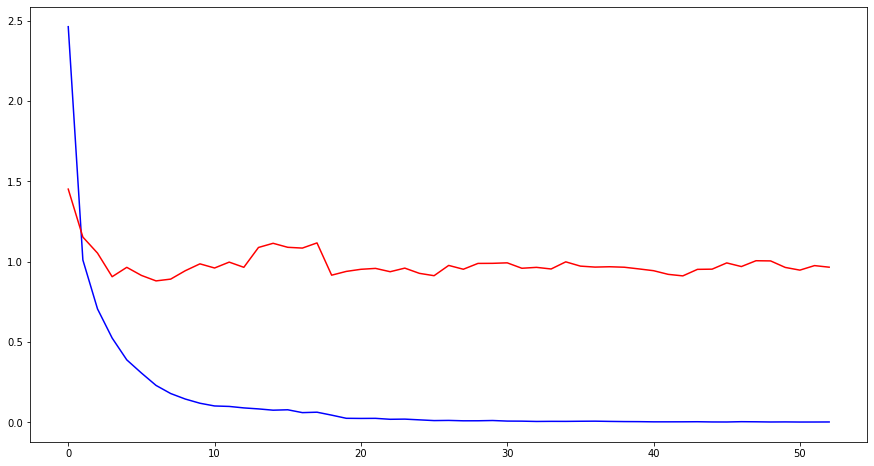

In [18]:
plt.figure(figsize=[15,8])
plt.plot(df.loss, 'b')
plt.plot(df.val_loss, 'r')
plt.show()

All right fellow kids, so what can we see here?  
  
Looks like this model is stucked at __80%__ of accuracy score on validation subset. But earlier we saw that this model processes about __95%__ of images without augmentation correctly. And what does it mean?

The dataset is not too big for classification of 120 breeds. Due to this fact, and due to the presence of randomness, it turned out that the image augmentation in the training dataset helped with increasing the quality, while the augmentation in the validation one only interfered.

But anyway. In the end, __94.86%__ and __94.60%__ are pretty good quality indicators, so I don't think I'll retrain my model later, because I'he already spent 2 week making it predict better. I started from VGGNet implementation, tried a lot of other techniques, and literally every additional percentage of accuracy made me happier.